### Variational Autoencoder

In [1]:
import matplotlib.pyplot as plt
from scipy import misc
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [2]:
# Hyperparameters
learning_rate = 1e-3
num_epochs = 10
batch_size = 128

# Architecture
num_features = 784
num_hidden_1 = 400
num_hidden_2 = 20

# Other
random_seed = 1

In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,transform=transforms.ToTensor()), 
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

In [4]:
torch.manual_seed(random_seed)

In [5]:
class VAE(nn.Module):
    def __init__(self, num_features, num_hidden_1, num_hidden_2):
        super(VAE, self).__init__()

        self.linear_1 = nn.Linear(num_features, num_hidden_1)
        self.linear_21 = nn.Linear(num_hidden_1, num_hidden_2)
        self.linear_22 = nn.Linear(num_hidden_1, num_hidden_2)
        self.linear_3 = nn.Linear(num_hidden_2, num_hidden_1)
        self.linear_4 = nn.Linear(num_hidden_1, num_features)

    def encode(self, x):
        h1 = F.relu(self.linear_1(x))
        return self.linear_21(h1), self.linear_22(h1)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h3 = F.relu(self.linear_3(z))
        return F.sigmoid(self.linear_4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [6]:
model = VAE(num_features=num_features, num_hidden_1=num_hidden_1, num_hidden_2=num_hidden_2)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#### Cost function

In [7]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, Variable(x.view(-1, num_features)), size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

#### Train and test the model

In [8]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data.view(-1, num_features))
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [9]:
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            recon_batch, mu, logvar = model(data.view(-1, num_features))
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison,
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

#### Train model and evaluate on test set while it is training

In [10]:
for epoch in range(1, num_epochs + 1):
    train(epoch)
    test(epoch)
    with torch.no_grad():
        sample = torch.randn(64, num_hidden_2)
        sample = model.decode(sample)
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')

Train Epoch: 1 [0/60000 (0%)]	Loss: 550.572632
Train Epoch: 1 [12800/60000 (21%)]	Loss: 187.615570
Train Epoch: 1 [25600/60000 (43%)]	Loss: 152.145340
Train Epoch: 1 [38400/60000 (64%)]	Loss: 138.745255
Train Epoch: 1 [51200/60000 (85%)]	Loss: 132.634949
====> Epoch: 1 Average loss: 164.2791
====> Test set loss: 119.4238
Train Epoch: 2 [0/60000 (0%)]	Loss: 123.696152
Train Epoch: 2 [12800/60000 (21%)]	Loss: 125.777008
Train Epoch: 2 [25600/60000 (43%)]	Loss: 124.701866
Train Epoch: 2 [38400/60000 (64%)]	Loss: 117.157608
Train Epoch: 2 [51200/60000 (85%)]	Loss: 117.832550
====> Epoch: 2 Average loss: 121.2722
====> Test set loss: 107.2897
Train Epoch: 3 [0/60000 (0%)]	Loss: 117.248535
Train Epoch: 3 [12800/60000 (21%)]	Loss: 116.939232
Train Epoch: 3 [25600/60000 (43%)]	Loss: 116.730835
Train Epoch: 3 [38400/60000 (64%)]	Loss: 113.294838
Train Epoch: 3 [51200/60000 (85%)]	Loss: 108.651718
====> Epoch: 3 Average loss: 114.3491
====> Test set loss: 102.6683
Train Epoch: 4 [0/60000 (0%)]	L

#### Check images generated from input -> encoder -> decoder -> input

/Users/hveiga/Desktop/Data_Science/dl-venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


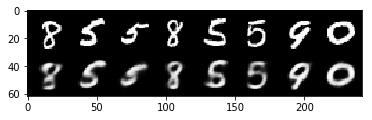

In [11]:
plt.imshow(misc.imread('results/reconstruction_1.png'))

#### Check images generated from random matrix ~ N(u, sigma) -> decoder -> input

/Users/hveiga/Desktop/Data_Science/dl-venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


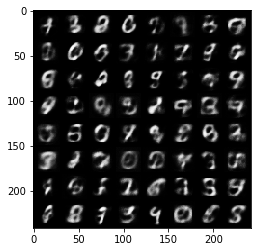

In [12]:
plt.imshow(misc.imread('results/sample_1.png'))

Check example with randomly generated matrix

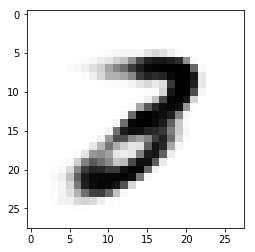

In [23]:
torch.manual_seed(123)
a = model.decode(torch.randn(1, num_hidden_2))
plt.imshow(a.data.numpy().reshape((28, 28)), cmap="binary")